In [9]:

import numpy as np
import pandas as pd
from math import exp
from itertools import product
import random 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


In [28]:
# Zaktualizowanie funkcji load_data o filtr usunięcia wierszy zawierających 'x' lub 'X'

def load_data(file_path):
    # Wczytywanie pliku, zakładając, że jest rozdzielony spacjami/tabulatorami
    df = pd.read_csv(file_path, sep='\t')
    
    # Nadanie nazw kolumn
    df.columns = ['chrom1', 'coord1', 'chrom2', 'coord2']
    
    # Usunięcie wierszy, które zawierają 'x' lub 'X'
    df = df[~df.apply(lambda x: 'x' in x.values or 'X' in x.values, axis=1)]
    
    # Konwersja kolumn do odpowiednich typów numerycznych i usunięcie wierszy, które nie zawierają 4 liczb
    for col in ['chrom1', 'coord1', 'chrom2', 'coord2']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    #df = df.dropna().astype(int)
    
    return df

# Ścieżka do pliku
file_path = "Data/GSM1173493_cell-1.txt"

# Wczytywanie danych
data = load_data(file_path)
# Wyświetlenie wczytanego dataframe
data.head()

,chrom1,coord1,chrom2,coord2
0,1,3023035,1,14942225
1,1,3065457,1,19796342
2,1,3312156,1,5315667
3,1,3377904,1,24338979
4,1,3390558,1,20722058


In [29]:
data = data[(data['chrom1'] == 13) & (data['chrom2'] == 13)]
len(data)

1192

In [33]:
# Skala dla siatki - to jest przykładowa wartość, może wymagać dostosowania
scale_factor = 5e5  # Skala dostosowana do zakresu danych
data['bead1'] = (data['coord1'] // scale_factor).astype(int)
data['bead2'] = (data['coord2'] // scale_factor).astype(int)
print(max(data['bead1']))

236


In [34]:
data

,chrom1,coord1,chrom2,coord2,bead1,bead2
22092,13,3532573,13,38283885,7,76
22093,13,3602362,13,3603799,7,7
22094,13,3651599,13,9439968,7,18
22095,13,3782481,13,27496414,7,54
22096,13,3789615,13,16026058,7,32
...,...,...,...,...,...,...
23324,13,117596483,13,117602906,235,235
23326,13,117988652,13,118011961,235,236
23327,13,118001370,13,118030580,236,236
23328,13,118266661,13,118677671,236,237


In [35]:
# Usuwanie duplikatow
data = data.drop_duplicates(subset=['bead1', 'bead2'], keep=False)
data['sorted_bead_pair'] = data.apply(lambda x: tuple(sorted((x['bead1'], x['bead2']))), axis=1)
data = data.drop_duplicates(subset=['sorted_bead_pair'], keep=False)
data.drop('sorted_bead_pair', axis=1, inplace=True)
data = data[data['bead1'] != data['bead2']]
print(len(data))

633


/var/folders/tq/f8kl87vd37qdfktfzkcp64800000gn/T/ipykernel_88770/530875078.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sorted_bead_pair'] = data.apply(lambda x: tuple(sorted((x['bead1'], x['bead2']))), axis=1)


In [36]:
data

,chrom1,coord1,chrom2,coord2,bead1,bead2
22094,13,3651599,13,9439968,7,18
22095,13,3782481,13,27496414,7,54
22096,13,3789615,13,16026058,7,32
22097,13,3850011,13,14891081,7,29
22098,13,3861788,13,39751609,7,79
...,...,...,...,...,...,...
23309,13,116120839,13,119044181,232,238
23311,13,116189984,13,117517524,232,235
23314,13,116553500,13,119510155,233,239
23326,13,117988652,13,118011961,235,236


In [ ]:
print(data)

In [37]:
n = max(max(data['bead1']),max(data['bead2']))

# Znalezienie sąsiadów dla każdej liczby
neighbors = {i + 1: set() for i in range(n)}  # Używamy zbioru, aby unikać duplikatów

for _, row in data.iterrows():
    bead1, bead2 = row['bead1'], row['bead2']
    neighbors[bead1].add(bead2)  # Dodajemy bead2 do zbioru sąsiadów bead1
    neighbors[bead2].add(bead1)  # Dodajemy bead1 do zbioru sąsiadów bead2
    
    
# Przykład: wypisanie wyników dla pierwszych 10 liczb
for i in range(10):
    print(f"Sąsiedzi {i+1} koralika: {list(neighbors[i + 1])}")

print(f'Liczba koralikow: {n}')

Sąsiedzi 1 koralika: []
Sąsiedzi 2 koralika: []
Sąsiedzi 3 koralika: []
Sąsiedzi 4 koralika: []
Sąsiedzi 5 koralika: []
Sąsiedzi 6 koralika: []
Sąsiedzi 7 koralika: [32, 79, 18, 93, 54, 29]
Sąsiedzi 8 koralika: [17, 10, 84, 20]
Sąsiedzi 9 koralika: [104, 31, 54, 15]
Sąsiedzi 10 koralika: [8, 17, 81]
Liczba koralikow: 240


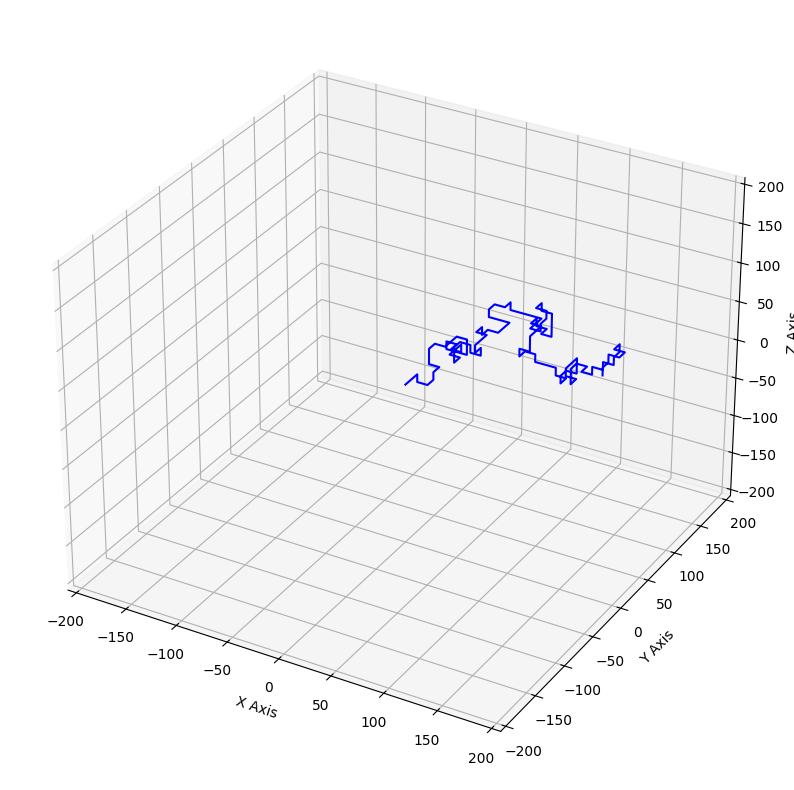

In [22]:
# Zdefiniujemy funkcję, która realizuje self-avoiding walk (SAW) w siatce 3D.
def self_avoiding_walk_3d(steps):
    # Początkowa pozycja w środku siatki
    position = np.array([0,0,0])
    walk = [tuple(position)]
    
    # Potencjalne ruchy
    potential_moves = [np.array(move) for move in [(10, 0, 0), (-10, 0, 0), (0, 10, 0), (0, -10, 0), (0, 0, 10), (0, 0, -10)]]
    
    i = 0
    while i < steps - 1: 
        np.random.shuffle(potential_moves)  # Mieszanie możliwych ruchów
        for move in potential_moves:
            new_position = position + move
            if tuple(new_position) not in walk:  # Sprawdzamy, czy nowa pozycja nie była odwiedzona
                position = new_position
                walk.append(tuple(position))
                i = i + 1
                break
            
    
    return walk

# Przeprowadzamy SAW
saw_walk = self_avoiding_walk_3d(steps=n)

# Konwertujemy spacer na format, który możemy wyświetlić
x_saw, y_saw, z_saw = zip(*saw_walk)

# Tworzenie wykresu SAW
fig_saw = plt.figure(figsize=(10, 10))
ax_saw = fig_saw.add_subplot(111, projection='3d')
ax_saw.plot(x_saw, y_saw, z_saw, c='blue')

# Ustawiamy etykiety osi
ax_saw.set_xlabel('X Axis')
ax_saw.set_ylabel('Y Axis')
ax_saw.set_zlabel('Z Axis')

# Ustawienie limitów osi
ax_saw.set_xlim(-200, 200)
ax_saw.set_ylim(-200, 200)
ax_saw.set_zlim(-200,200)

# Wyświetlamy wykres SAW
plt.show()
coordinates= np.column_stack((x_saw, y_saw, z_saw)).astype(float)

In [25]:
coordinate = coordinates[10].copy()
move_range = 3
random_move = [random.uniform(-move_range, move_range), random.uniform(-move_range, move_range), random.uniform(-move_range, move_range)]
new_position = coordinate + random_move
print(f'Coordinate: {coordinate},\n random_move: {random_move},\n new_position: {new_position}')
coordinates[10] = new_position
print(coordinates[10])

Coordinate: [-2.93891277 44.37347645 15.75998929],
 random_move: [-1.2726088602410426, 1.585254298615335, 0.4473572353661899],
 new_position: [-4.21152163 45.95873075 16.20734653]
[-4.21152163 45.95873075 16.20734653]


In [13]:
len(coordinates)

120

In [10]:
def calculate_theta_ij_simple(contact_matrix, i, j, d2, mu2):
    theta_ij_simple = 0

    # Iterujemy przez zakres od i-d2 do i+d2+1 dla xp
    for xp in range(i - d2, i + d2 + 1):
        # Iterujemy przez zakres od j-d2 do j+d2+1 dla yp
        for yp in range(j - d2, j + d2 + 1):
            # Sprawdzamy czy (xp, yp) jest w granicach macierzy
            if 0 <= xp < contact_matrix.shape[0] and 0 <= yp < contact_matrix.shape[1]:
                # Sprawdzamy czy istnieje kontakt
                if contact_matrix[xp, yp] == 1:
                    # Obliczamy wartość funkcji Gaussa i dodajemy do sumy
                    gauss_value = np.exp(-((xp - i)**2 + (yp - j)**2) / mu2)
                    theta_ij_simple += gauss_value

    # Ograniczamy wynik do maksymalnie 1
    theta_ij_simple = min(theta_ij_simple, 1)
    return theta_ij_simple

def calculate_contact_matrix(d2,mu2,n,data):
    contact_matrix1 = np.zeros((n,n), dtype=int)
    
    for _, row in data.iterrows():
        bead1 = int(row['bead1']) - 1  # Odejmujemy 1, aby indeksowanie było od 0
        bead2 = int(row['bead2']) - 1
        contact_matrix1[bead1, bead2] = 1
        contact_matrix1[bead2, bead1] = 1  # Zapewnienie symetrii
    
    contact_matrix2 = np.zeros((n, n), dtype=float)
        
    for i in range(n):
        for j in range(i):
            contact_matrix2[i][j]=calculate_theta_ij_simple(contact_matrix1,i,j,d2,mu2)
            contact_matrix2[j][i]=contact_matrix2[i][j]
    return contact_matrix2

def calculate_loss(contact_matrix2, coordinates, d, p, f, n, mu1, theta1, a, b):
    d1 = d / theta1**(1/3)
    L = 0.0
    for i in range(len(coordinates)):
        for j in range(i):
            dist = np.linalg.norm(coordinates[i] - coordinates[j])  # Obliczenie d(i, j)
            if contact_matrix2[i, j] >= 1:
                L += ((dist - d)**2) / (d**2)
            elif contact_matrix2[i, j] > theta1:
                L += a*(1 - np.exp(-((dist - d / (contact_matrix2[i, j]**(1/3)))**2) / mu1))
            else:
                L += b*(1 - 1 / (1 + np.exp(-(dist - (d1 - p)) / f)))
    return L

contact_matrix = calculate_contact_matrix(int(n/2), 5, n, data[['bead1','bead2']])
loss = calculate_loss(contact_matrix, coordinates, 16, 1, 0.1, n, 20, 0.7, 1, 1)
print("Wartość funkcji straty L:", loss)

Wartość funkcji straty L: 16795.22281762335


In [ ]:
def total_loss_for_bead(contact_matrix2, coordinates, i, d, p, f, theta1, n, a, b, mu1):
    L = 0.0
    d1 = d / theta1 ** (1/3)
    for j in range(n):
            if(j != i):
                dist = np.linalg.norm(coordinates[i] - coordinates[j])  # Obliczenie d(i, j)
                if contact_matrix2[i, j] >= 1:
                    L += ((dist - d)**2) / (d**2)
                elif (contact_matrix2[i, j]>theta1):
                    L += a * (1-np.exp(-(dist-d/(contact_matrix2[i,j]**(1/3)))**2/mu1))
                else:
                    L += b*(1 - 1 / (1 + exp(-(dist - (d1 - p)) / f)))
    return L


def make_move_optimized(contact_matrix2, coordinates, d, p, f, theta1, n, a, b, d3, mu1,c=1):
    i = random.randint(0, n-1)
    directions = np.array([
        [-1, -1, -1], [-1, -1, 0], [-1, -1, 1], [-1, 0, -1], [-1, 0, 0], [-1, 0, 1],
        [-1, 1, -1], [-1, 1, 0], [-1, 1, 1], [0, -1, -1], [0, -1, 0], [0, -1, 1],
        [0, 0, -1], [0, 0, 1], [0, 1, -1], [0, 1, 0], [0, 1, 1], [1, -1, -1],
        [1, -1, 0], [1, -1, 1], [1, 0, -1], [1, 0, 0], [1, 0, 1], [1, 1, -1],
        [1, 1, 0], [1, 1, 1]
    ])

    coordinate = coordinates[i].copy()
    initial_loss = total_loss_for_bead(contact_matrix2, coordinates, i, d, p, f, theta1, n, a, b, mu1)
    
    changes = []
    for vector in directions:
        new_position = coordinate + vector*random.random()*c
        if ((i == 0 or i == n-1) and np.linalg.norm(new_position - coordinates[i + (1 if i == 0 else -1)]) <= d3):
            continue
        if 0 < i < n-1 and (np.linalg.norm(new_position - coordinates[i-1]) > d3 or np.linalg.norm(new_position - coordinates[i+1]) > d3):
            continue
        coordinates[i] = new_position
        new_loss = total_loss_for_bead(contact_matrix2, coordinates, i, d, p, f, theta1, n, a, b, mu1)
        coordinates[i] = coordinate
        loss_change = new_loss - initial_loss
        changes.append((loss_change, new_position))
    
    # Filter and sort changes based on sign
    negative_changes = [(change, pos) for change, pos in changes if change < 0]
    
    if negative_changes:
        # Choose from negative changes with probability proportional to the magnitude of loss change
        weights_neg = [abs(loss) for loss, _ in negative_changes]
        _, chosen_position = random.choices(negative_changes, weights=weights_neg)[0]
    else:
        return coordinates  # No valid moves available

    # Update the position if the chosen position is unique
    if is_position_unique(coordinates, chosen_position, i):
        coordinates[i] = chosen_position

    return coordinates
       
    
def make_move(contact_matrix2,coordinates, d, p, f, theta1, n, a, b, d3, mu1):
    
    i = random.randint(0, n-1)
    
    directions = {
    'left-back-down': [-1, -1, -1],
    'left-back': [-1, -1, 0],
    'left-back-up': [-1, -1, 1],
    'left-down': [-1, 0, -1],
    'left': [-1, 0, 0],
    'left-up': [-1, 0, 1],
    'left-forward-down': [-1, 1, -1],
    'left-forward': [-1, 1, 0],
    'left-forward-up': [-1, 1, 1],
    'back-down': [0, -1, -1],
    'back': [0, -1, 0],
    'back-up': [0, -1, 1],
    'down': [0, 0, -1],
    'up': [0, 0, 1],
    'forward-down': [0, 1, -1],
    'forward': [0, 1, 0],
    'forward-up': [0, 1, 1],
    'right-back-down': [1, -1, -1],
    'right-back': [1, -1, 0],
    'right-back-up': [1, -1, 1],
    'right-down': [1, 0, -1],
    'right': [1, 0, 0],
    'right-up': [1, 0, 1],
    'right-forward-down': [1, 1, -1],
    'right-forward': [1, 1, 0],
    'right-forward-up': [1, 1, 1]
    }
    coordinate = coordinates[i].copy()
    best_position=coordinates[i]
    best_loss_change = 0
    initial_loss =  total_loss_for_bead(contact_matrix2,coordinates, i, d, p, f,theta1,n,a,b,mu1)

    for direction, vector in directions.items():
        new_position = coordinate + np.array(vector)
        if ((i == 0 and np.linalg.norm(new_position - coordinates[i+1]) <= d3) or (i == n-1 and np.linalg.norm(new_position - coordinates[i-1]) <= d3)
        or (np.linalg.norm(new_position - coordinates[i-1]) <= d3 and np.linalg.norm(new_position - coordinates[i+1]) <= d3)):
            coordinates[i] = new_position
            new_loss =   total_loss_for_bead(contact_matrix2,coordinates, i, d, p, f,theta1,n,a,b,mu1)
            if (new_loss - initial_loss) < best_loss_change:
                best_loss_change = new_loss - initial_loss
                best_position = new_position
            coordinates[i]=coordinate
    
    
    if(best_loss_change<0):
        if(is_position_unique(coordinates,best_position,i)):
            coordinates[i]=best_position


def is_position_unique(coordinates, best_position, current_index):
    # Przeszukaj wszystkie koordynaty z wyjątkiem koordynatu na indeksie 'current_index'
    for index, pos in enumerate(coordinates):
        if index != current_index:
            # Sprawdź, czy nowa pozycja pokrywa się z istniejącą
            if np.allclose(pos, best_position):
                return False
    return True
 

for j in range(20000):
    coordinates = coordinates.astype(float)
    make_move_optimized(contact_matrix2,coordinates,16,1,0.1,0.7,n,1,1,100,0.5)
    if(j%500==499):
        loss=calculate_loss(contact_matrix2, coordinates, 16, 1, 0.1,n,1,0.7,1,1)
        print(loss)
        unique_rows = np.unique(coordinates, axis=0)
        print(unique_rows.shape[0])
        if(loss<5):
            break

In [22]:
from points_io import point_reader, save_points_as_pdb
data1 = np.array(np.unique(coordinates, axis=0))
save_points_as_pdb(data1, 'proba5.pdb')

File proba5.pdb saved...


In [14]:
directions = np.array([
        [-1, -1, -1], [-1, -1, 0], [-1, -1, 1], [-1, 0, -1], [-1, 0, 0], [-1, 0, 1],
        [-1, 1, -1], [-1, 1, 0], [-1, 1, 1], [0, -1, -1], [0, -1, 0], [0, -1, 1],
        [0, 0, -1], [0, 0, 1], [0, 1, -1], [0, 1, 0], [0, 1, 1], [1, -1, -1],
        [1, -1, 0], [1, -1, 1], [1, 0, -1], [1, 0, 0], [1, 0, 1], [1, 1, -1],
        [1, 1, 0], [1, 1, 1]
    ])